#### Проект. Рекомендательные системы в банковской сфере. Моделирование

Содержание  
 - Начало: импорт библиотек, настройка параметров, определения функций
 - Запуск MLFlow
 - Обучение модели
 - Подготовка функций для встраивания модели в сервис предсказаний
 - Получение и интерпретация метрик
 - Сравнение метрик модели с константными предсказаниями
 - Итоги этапа моделирования

##### Начало: импорт библиотек, настройка параметров, определения функций

In [1]:
# Import essential libraries for data manipulation and I/O operations
import pandas as pd
import numpy as np
import os
import json
import joblib
import warnings
import matplotlib.pyplot as plt
import requests
from typing import Optional, List, Dict
import subprocess
from dotenv import load_dotenv
import psutil

# Import CatBoost for machine learning tasks
from catboost import CatBoostClassifier

# Import metrics from sklearn for evaluating model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

# Import preprocessing and pipeline tools from sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

# Custom utility imports for data processing
from data_utils import new_columns, attrs
from data_utils import DataFrameProcessor, frequency_encoding, get_X_y

# MLflow for model tracking
import mlflow

# Set global options for precision in numpy and pandas formatting
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

# Constant for reproducibility
RANDOM_STATE = 42

# Optionally, suppress runtime warnings (uncomment if needed)
#warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load environment variables from .env file
load_dotenv()

# Load environment variables
env_var_names: list[str] = [
    'DATA_DIR', 'MODEL_DIR',
    'TRAIN_PARQUET', 'TEST_PARQUET',
    'TRACKING_SERVER_CONN', 'MODEL_PKL', 'FITTED_MODEL', 'MODEL_PARAMS'
]

# Loop to load environment variables dynamically and set them globally
for var in env_var_names:
    globals()[var] = os.getenv(var)


In [2]:
def calculate_roc_auc(y_true: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    """
    Calculate ROC AUC scores (micro, macro, and average) for multi-output classification.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.

    Returns:
    dict: ROC AUC scores.
    """
    if isinstance(y_pred_proba, list):
        y_pred_proba = np.array(y_pred_proba)

    if len(y_pred_proba.shape) == 3:
        y_pred_proba_class_1 = y_pred_proba[:, :, 1].T
    else:
        y_pred_proba_class_1 = y_pred_proba

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values

    # Filter columns with more than one unique value
    valid_columns = [col for col in range(y_true.shape[1]) if len(np.unique(y_true[:, col])) > 1]

    return {
        'micro': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='micro'),
        'macro': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='macro'),
        'average': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='weighted')
    }


def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray, zero_division: int = 0) -> pd.DataFrame:
    """
    Calculate various classification metrics such as Accuracy, Precision, Recall, F1, and ROC AUC.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred (np.ndarray): Predicted labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    zero_division (int): Determines the behavior when division by zero occurs (default is 0).

    Returns:
    pd.DataFrame: DataFrame with calculated metrics for micro, macro, and average scores.
    """
    metrics = {
        'Accuracy': {
            'micro': -1,
            'macro': -1,
            'average': accuracy_score(y_true, y_pred)
        },
        'Precision': {
            'micro': precision_score(y_true, y_pred, average='micro', zero_division=zero_division),
            'macro': precision_score(y_true, y_pred, average='macro', zero_division=zero_division),
            'average': precision_score(y_true, y_pred, average='weighted', zero_division=zero_division)
        },
        'Recall': {
            'micro': recall_score(y_true, y_pred, average='micro', zero_division=zero_division),
            'macro': recall_score(y_true, y_pred, average='macro', zero_division=zero_division),
            'average': recall_score(y_true, y_pred, average='weighted', zero_division=zero_division)
        },
        'F1': {
            'micro': f1_score(y_true, y_pred, average='micro', zero_division=zero_division),
            'macro': f1_score(y_true, y_pred, average='macro', zero_division=zero_division),
            'average': f1_score(y_true, y_pred, average='weighted', zero_division=zero_division)
        },
        'ROC AUC': calculate_roc_auc(y_true, y_pred_proba)
    }

    return pd.DataFrame(metrics).T


def plot_roc_curve(y_true: np.ndarray, y_pred_proba: np.ndarray, label_name: str) -> None:
    """
    Plot the ROC curve for binary classification.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    label_name (str): Label for the ROC curve.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.4f})')

##### Запуск MLFlow

Сервер MLFlow лучше запустить (см. Instructions.md):
 - скриптом sh run_mlflow.sh
 - в составе общего контейнера docker compose up --build
  
Если запустить MLFlow как субпроцесс в Jupyter, его нужно будет останавливать вручную

```
# Fetch necessary environment variables for PostgreSQL and S3
DB_DESTINATION_USER = os.getenv('DB_DESTINATION_USER')
DB_DESTINATION_PASSWORD = os.getenv('DB_DESTINATION_PASSWORD')
DB_DESTINATION_HOST = os.getenv('DB_DESTINATION_HOST')
DB_DESTINATION_PORT = os.getenv('DB_DESTINATION_PORT')
DB_DESTINATION_NAME = os.getenv('DB_DESTINATION_NAME')
S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')

# Construct the PostgreSQL connection string
POSTGRES_SQL_CONN = f"postgresql://{DB_DESTINATION_USER}:{DB_DESTINATION_PASSWORD}@{DB_DESTINATION_HOST}:{DB_DESTINATION_PORT}/{DB_DESTINATION_NAME}"

# Command to start MLflow server
mlflow_command = [
    "mlflow", "server",
    "--backend-store-uri", POSTGRES_SQL_CONN,
    "--registry-store-uri", POSTGRES_SQL_CONN,
    "--default-artifact-root", f"s3://{S3_BUCKET_NAME}",
    "--no-serve-artifacts",
    "--host", "0.0.0.0",
    "--port", "5000"
]

# Run the MLflow server command in the background
process = subprocess.Popen(mlflow_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Output the PID of the process to confirm it's running
print(f"MLflow server started with PID: {process.pid}")
```

In [3]:
# MLFlow сервер должен быть запущен

def check_mlflow_server(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print("MLFlow сервер запущен.")
            return True
        else:
            print("MLFlow сервер вернул статус:", response.status_code)
            return False
    except requests.exceptions.ConnectionError:
        raise Exception("Не удалось связаться с MLFlow server.") 


if check_mlflow_server(TRACKING_SERVER_CONN):
    EXPERIMENT_NAME = 'Спринт 6: Проект'
    mlflow.set_tracking_uri(TRACKING_SERVER_CONN)
    mlflow.set_registry_uri(TRACKING_SERVER_CONN)

MLFlow сервер запущен.


In [4]:
active_run = mlflow.active_run()
if active_run:
    print(f"Активный запуск: {active_run.info.run_id}")
else:
    print("Активных запусков нет.")

Активных запусков нет.


In [5]:
RUN_NAME = "CBC"
REGISTRY_MODEL_NAME = 'model_sprint_6_2'

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

run = mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id)
print(f"Запуск текущего эксперимента с ID: {run.info.run_id}")


Запуск текущего эксперимента с ID: b84e9205f8774ce5b86fc4c9dffdf629


##### Обучение модели

In [6]:
#model = joblib.load(MODEL_DIR + MODEL_PKL)
model = joblib.load(MODEL_DIR + FITTED_MODEL)

Параметры модели, которую мы построили на предыдущем этапе:  
CatBoostClassifier(iterations=100, verbose=0, class_weights = [1, 4])

Среди задач проекта нет глубокой оптимизации модели.  
Поэтому получим результат с некоторыми упрощениями:  
 - оставим небольшок количество итераций (100). Исходя из структуры данных, увеличение количества итераций до 500-1000 улучшит результат, но обучение на двух десятках таргетов займет много времени
 - нужно обязательно "утяжелить" миноритарный класс, подбор соотношения - задача дальнейшей оптимизации модели
 - остальные параметры оставим по умолчанию, хотя может быть необходимость настроить параметры деревьев, learning rate и т.д.
 - также усечем тренировочные данные с 14 до 8 месяцев. Так мы сократим время обучения, а также сконцентрируемся на более "свежих" данных.


In [7]:
%%time
# ~ 16 min

df_train = pd.read_parquet(DATA_DIR + TRAIN_PARQUET)

start_date_of_train = '2015-07-28'
df_train = df_train[df_train.fetch_date >= start_date_of_train]

df_test = pd.read_parquet(DATA_DIR + TEST_PARQUET)

X_train, y_train = get_X_y(df_train, df_train.attrs['target__'])
X_test, y_test = get_X_y(df_test, df_test.attrs['target__'])

target_cols = [col for col in y_train.columns if y_train[col].nunique() > 1]

CPU times: user 5.41 s, sys: 2.5 s, total: 7.91 s
Wall time: 4.95 s


In [8]:
#model.fit(X_train, y_train[target_cols])

Можно вывести важности признаков, но эти данные потребуют дополнительного анализа по всем таргетам.

In [9]:
df_importance = pd.DataFrame([model.steps[2][1].estimators_[0].get_feature_importance()], columns=X_train.columns).T.sort_values(by=0, ascending=False)
df_importance[df_importance[0] > 1]

,0
gender,40.6936
age,11.1380
ind_employee,10.8144
ind_1m_pension_obligation_account,8.5310
ind_client_activity,6.8269
id,3.9839
ind_1m_tax_account,2.4307
ind_1m_salary_acc,2.3021
ind_1m_home_acc,2.1473
ind_new_client,1.8689


(Для первого таргета пол стоит на первом месте, хотя общей зависимости таргетов от этой переменной не было.)
  
Получим данные для метрик.

In [10]:
joblib.dump(model, MODEL_DIR + FITTED_MODEL)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_true = y_test[target_cols]

##### Подготовка функций для встраивания модели в сервис предсказаний

Для мониторинга предсказаний нам потребуются имена таргетов на русском (для FastAPI) и на английском (Graphite принимает только ASCII названия).  
Для обработки часто встречающихся пропусков в 'income' сохраним среднее значение как параметр.

In [11]:
target_names = [X_train.attrs[x[len('target__'):]][0] for x in target_cols]
target_names_eng = [X_train.attrs[x[len('target__'):]][1] for x in target_cols]
income_mean = X_train['income'].mean()

model_params = {
    'target_names': target_names,
    'target_names_eng': target_names_eng,
    'income_mean': income_mean
}

with open(MODEL_DIR + MODEL_PARAMS, 'w') as f:
    json.dump(model_params, f)

mlflow.log_artifact(MODEL_DIR + MODEL_PARAMS)

Для тестирования сервиса нам нужно будет генерировать json запросы, а для получения предсказаний нужен DataFrame.
Для этого создадим некоторые функции преобразования, смысл которых понятен из аннотаций.

In [12]:
def safe_strftime(date_value: pd.Timestamp) -> Optional[str]:
    """
    Safely convert a pandas Timestamp to a string in 'dd-mm-yyyy' format.
    If the value is NaT (not a time), return None.

    Parameters:
    - date_value (pd.Timestamp): A timestamp to convert.

    Returns:
    - str or None: The formatted date string or None if the value is NaT.
    """
    if pd.isnull(date_value):  # Check for NaT (Not a Time)
        return None
    return date_value.strftime('%d-%m-%Y')  # Format the date as dd-mm-yyyy


def save_row_to_json(row: pd.Series, json_file: str) -> None:
    """
    Save a pandas Series (row) to a JSON file, converting datetime fields safely.

    Parameters:
    - row (pd.Series): The row of data to save.
    - json_file (str): The path to the JSON file to save the data.

    Returns:
    - None: The function writes the row to a file and doesn't return anything.
    """
    row = row.copy()  # Make a copy of the row to avoid modifying the original
    
    # Safely convert datetime fields to string format
    row['fetch_date'] = safe_strftime(row['fetch_date'])
    row['registration_date'] = safe_strftime(row['registration_date'])
    row['last_date_as_primary'] = safe_strftime(row['last_date_as_primary'])
    
    # Convert the row to JSON format
    json_data = row.to_json(orient='index', indent=4)
    
    # Write the JSON data to the specified file
    with open(json_file, 'w') as f:
        f.write(json_data)

save_row_to_json(X_test.iloc[376088], 'sample.json')


In [13]:
def load_row_from_json(json_file: str) -> pd.DataFrame:
    """
    Load a row from a JSON file and convert it into a pandas DataFrame.
    Handles datetime fields and assigns a mean value to the 'income' column if it's missing.

    Parameters:
    - json_file (str): Path to the JSON file.

    Returns:
    - pd.DataFrame: A DataFrame containing the loaded row.
    """
    # Load the JSON data as a pandas Series
    row_loaded = pd.read_json(json_file, typ='series')
    
    # Convert string dates back into datetime format
    row_loaded['fetch_date'] = pd.to_datetime(row_loaded['fetch_date'], format='%d-%m-%Y')
    row_loaded['registration_date'] = pd.to_datetime(row_loaded['registration_date'], format='%d-%m-%Y')
    row_loaded['last_date_as_primary'] = pd.to_datetime(row_loaded['last_date_as_primary'], format='%d-%m-%Y')
    
    # Handle missing 'income' value by assigning the mean income
    if row_loaded['income'] is None:
        row_loaded['income'] = income_mean
    
    # Return as a single-row DataFrame
    return pd.DataFrame([row_loaded])


def interpret_predictions(predictions: list, lang: str = 'rus') -> Dict[str, int]:
    """
    Interpret the model predictions by mapping the prediction columns to target names.

    Parameters:
    - predictions (list): List of predicted values.
    - lang (str): Language for target names, 'rus' for Russian, 'eng' for English.

    Returns:
    - dict: A dictionary mapping target names to predicted values.
    """
    # Select appropriate target names based on language
    if lang == 'rus':
        targets = target_names
    else:
        targets = target_names_eng
    
    # Map the predictions to target names
    res = {name: int(pred) for pred, name in zip(predictions, targets)}
    return res


prediction = model.predict(load_row_from_json('sample.json'))[0]

predictions_dict = interpret_predictions(prediction, lang='eng')

for target, prediction in predictions_dict.items():
    print(target, prediction)

Bank Guarantee 0
Checking Account 1
Derivatives Account 0
Payroll Account 1
Junior Account 0
Special Account 3 0
Operations Account 0
Special Account 2 0
Short-Term Deposit 0
Medium-Term Deposit 0
Long-Term Deposit 0
Digital Account 0
Cash Funds 0
Mortgage 0
Pension Plan 0
Loans 0
Tax Account 0
Credit Card 0
Securities 0
Home Account 0
Salary Account 1
Pension Obligation Account 1
Debit Account 0


В итоге мы создали образец json в файле sample.json и получили функцию для вывода предсказаний модели на английском и русском языках.  

Вернемся к оценке предсказаний.

##### Получение и интерпретация метрик

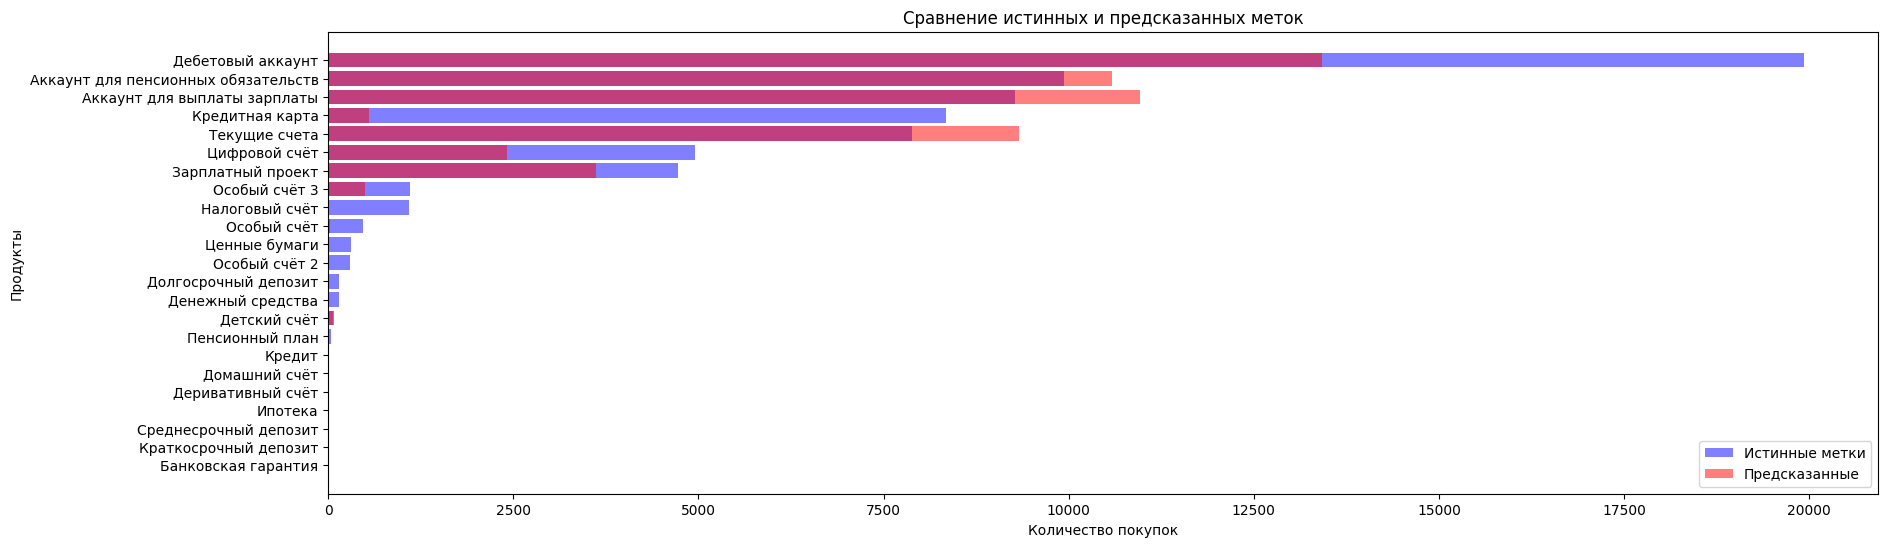

In [14]:
plot_data = pd.DataFrame({
    'True': y_true.sum(axis=0),
    'Predicted': np.sum(y_pred, axis=0)
})

plot_data_sorted = plot_data.sort_values(by='True')

plt.figure(figsize=(20, 6))
plt.title(f"Сравнение истинных и предсказанных меток")
plt.ylabel("Продукты")
plt.xlabel("Количество покупок")

y_labels = [df_train.attrs[col[8:]][0] for col in plot_data_sorted.index]
plt.barh(y_labels, plot_data_sorted['True'], label='Истинные метки', alpha=0.5, color='b')
plt.barh(y_labels, plot_data_sorted['Predicted'], label='Предсказанные', alpha=0.5, color='r')

plt.legend(loc='lower right')

plot_path = "compare_plot.png"
plt.savefig(plot_path)

plt.show()


mlflow.log_artifact(plot_path)

os.remove(plot_path)

Видим, что модель (неглубоко обученная) неплохо собирает положительные таргеты, отличает их друг от друга, но ошибается в частоте предсказаний,  неравномерно недооценивает/переоценивает различные таргеты.  
Залогируем модель, а потом и метрики.

In [15]:
warnings.filterwarnings("ignore", category=UserWarning)

X_test['ind_spouse_employee'] = X_test['ind_spouse_employee'].fillna(0)

mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path='models',
    registered_model_name=REGISTRY_MODEL_NAME,
    signature=mlflow.models.infer_signature(X_test[:10], model.predict(X_test[:10])),
    await_registration_for=60,
    pip_requirements='requirements.txt'
)

mlflow.log_params(model.get_params())

Registered model 'model_sprint_6_2' already exists. Creating a new version of this model...
2024/09/14 08:43:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: model_sprint_6_2, version 13
Created version '13' of model 'model_sprint_6_2'.


In [16]:
metrics = calculate_metrics(y_true, y_pred, y_pred_proba)

display(metrics)

metrics_dict = {
    f'{metric}_{metric_type}': metrics.loc[metric, metric_type]
    for metric in metrics.index
    for metric_type in metrics.columns
}

mlflow.log_metrics(metrics_dict)

,micro,macro,average
Accuracy,-1.0000,-1.0000,0.8285
Precision,0.3167,0.1899,0.2988
Recall,0.2371,0.1171,0.2371
F1,0.2712,0.1298,0.2499
ROC AUC,0.9581,0.8324,0.8791


В целом, картина полчилась адекватная.  
Accuracy высокая из-за превалирующего количества предсказаний мажоритарного класса (0).  
Микро-метрики, то есть усредненные по всем наблюдениям, в целом лучше, чем макро-усредненные по классам, т.к. классы очень разные.  
Ну и высокая ROC-AUC, показывающая, что модель хорошо отличает класс 1 от класса 0.  
В общем, для разреженных, несбалансированны данных и неоптимизированной модели, предсказание покупки в 25-30% случаев - неплохой результат.

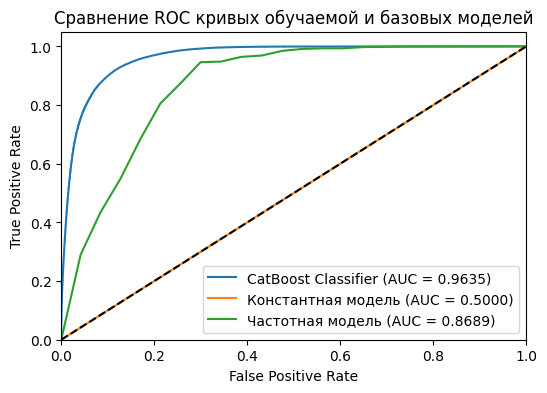

In [17]:
plt.figure(figsize=(6, 4))
y_pred_proba_class_1 = np.array(y_pred_proba)[:, :, 1].T 
plot_roc_curve(y_true, y_pred_proba_class_1, 'CatBoost Classifier')

constant_baseline_proba = np.full(y_true.shape, 0.5)
plot_roc_curve(y_true, constant_baseline_proba, 'Константная модель')

label_frequencies = y_train[target_cols].mean(axis=0)
frequency_based_baseline_proba = np.tile(label_frequencies.values, (y_true.shape[0], 1))
plot_roc_curve(y_true, frequency_based_baseline_proba, 'Частотная модель')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC кривых обучаемой и базовых моделей')
plt.legend(loc='lower right')
plt.show()

##### Сравнение метрик модели с константными предсказаниями

Как видно из графика, частотная baseline модель может показать высокую ROC AUC, если будет выбирать самые популярные продукты.  
Сравним нашу модель с константными более основательно.  
Попробуем в каждом таргете сохранить средние значения по всем наблюдениям.

In [22]:
threshold = 0.02

y_train.mean(axis=0)[y_train.mean(axis=0) > 0.02]

target__ind_1m_checking_acc                 0.0289
target__ind_1m_credit_card                  0.0230
target__ind_1m_salary_acc                   0.0263
target__ind_1m_pension_obligation_account   0.0289
target__ind_1m_debit_account                0.0556
dtype: float64

In [23]:
n_rows = y_pred.shape[0]
n_columns = y_pred.shape[1]


mean_class_probs = y_train.mean(axis=0)
constant_baseline_proba = np.array([
    np.tile([1 - mean_class_probs.iloc[i], mean_class_probs.iloc[i]], (n_rows, 1)) 
    for i in range(n_columns)
])

y_pred_constant = (constant_baseline_proba[:, :, 1].T > threshold).astype(int)

print("Метрики базовой модели на константных средних")
calculate_metrics(y_true, y_pred_constant, constant_baseline_proba)

# Acc = 0, т.к. не было случаев совпадения предсказаний  по всем меткам сразу (т.е. где 5 выбранных таргетов == 1)

Метрики базовой модели на константных средних


,micro,macro,average
Accuracy,-1.0000,-1.0000,0.0000
Precision,0.0190,0.0033,0.0182
Recall,0.4391,0.1739,0.4391
F1,0.0365,0.0064,0.0348
ROC AUC,0.5692,0.5000,0.5000


Видим, что полнота даже выше, чем у нашей модели, то есть константная модель на средних собирает больше 1, но, к сожалению, очень неточно, из-за чего точность < 2%.  Тут даже Accuracy == 0, то есть константы не различают классы.  
  
Другая модель пытается сохранить частоту появления положительных предсказаний для каждого таргета.

In [24]:
y_pred_frequency_based = np.zeros_like(y_true)

for i in range(n_columns):
    num_ones = int(y_train.iloc[:, i].mean() * n_rows)
    ones_indices = np.random.choice(n_rows, num_ones, replace=False)
    y_pred_frequency_based[ones_indices, i] = 1

class_1_frequencies = y_train.mean(axis=0)
y_pred_proba_frequency_based = np.array([
    np.tile([1 - class_1_frequencies.iloc[i], class_1_frequencies.iloc[i]], (n_rows, 1))
    for i in range(n_columns)
])

print("Метрики частотной базовой модели")
metrics = calculate_metrics(y_true, y_pred_frequency_based, y_pred_proba_frequency_based)
metrics

Метрики частотной базовой модели


,micro,macro,average
Accuracy,-1.0000,-1.0000,0.7450
Precision,0.0156,0.0072,0.0230
Recall,0.0131,0.0056,0.0131
F1,0.0142,0.0034,0.0155
ROC AUC,0.5692,0.5000,0.5000


Значение Accuracy высокое, т.к. частоты 0 тоже похожи на реальные, но остальные метрики также на уровне погрешности.  
Таким образом, наша обученная модель не просто знает частоту и средние значения таргетов, а хорошо умеет отделять класс 1 от класса 0 и отличать таргеты друг от друга.

In [25]:
run_id = run.info.run_id
run_details = mlflow.get_run(run_id)

params = run_details.data.params
print("Залогированы параметры:", params)

print("Залогированы метрики:", run_details.data.metrics)

registered_models = mlflow.search_registered_models()

model_found = any(model.name == REGISTRY_MODEL_NAME for model in registered_models)
if model_found:
    print(f"Модель {REGISTRY_MODEL_NAME} была зарегистрирована.")
else:
    print(f"Модель {REGISTRY_MODEL_NAME} НЕ была зарегистрирована.")


Залогированы параметры: {'memory': 'None', 'steps': "[('preprocessor', DataFrameProcessor()), ('encoder', ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',\n                  transformers=[('num', MinMaxScaler(),\n                                 ['age', 'tenure_months', 'income',\n                                  'fetch_year', 'fetch_month',\n                                  'number_of_products']),\n                                ('onehot', OneHotEncoder(drop='first'),\n                                 ['gender', 'client_type_1m',\n                                  'client_activity_1m', 'ind_foreigner',\n                                  'client_segment']),\n                                ('freq',\n                                 FunctionTransformer(func=<function frequency_encoding at 0x7efefd4aeef0>),\n                                 ['entry_channel', 'province_code'])])), ('model', MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier obje

In [26]:
mlflow.end_run()
print("Запуск эксперимента окончен.")

active_run = mlflow.active_run()
if active_run:
    print(f"Активный запуск: {active_run.info.run_id}")
else:
    print("Активных запусков нет.")

2024/09/14 08:46:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run CBC at: http://127.0.0.1:5000/#/experiments/14/runs/b84e9205f8774ce5b86fc4c9dffdf629.
2024/09/14 08:46:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/14.


Запуск эксперимента окончен.
Активных запусков нет.


##### Итоги этапа моделирования
 - поднят сервер MLFlow
 - загружен тренировочный датасет и сохраненная модель
 - подобран объем тренировочных данных (данные за 8 месяцев), тестовых данных (за 2 месяца) и параметры модели (малое количество итераций = 100, веса классов = [1, 4])
 - проведена подготовка к встраиванию модели в сервис предсказаний
 - получены метрики модели и проведена их интерпретация:
   - Precision	0.3167
   - Recall	0.2371
   - F1	0.2712
   - ROC AUC	0.9581
 - проведене сравнение результатов предсказаний модели с константными предсказаниями
 - на протяжении всего этапа производилось логирование артефактов и метрик в текущем запуске эксперимента MLFlow
 - обученная модель залогирована, запуск эксперимента окончен
 - построенная структура позволяет проводить оптимизацию (кросс-валидацию) пайплайна обработки данных и подбора алгорима обучения и гиперпараметров с использованием инструментов sklearn или Optuna